In [149]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as pl

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

from torchvision import transforms
from torchvision.models import resnet50

from PIL import Image
from Models.CNN_model import CNN

In [150]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [151]:
cnn = CNN()
cnn.load_state_dict(torch.load('../assets/cnn_model.pth', map_location = device))
cnn.eval()

/tmp/ipykernel_16546/1789273082.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn.load_state_dict(torch.load('../assets/cnn_model.pth', map_location = device))


CNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=12544, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [152]:
classes: dict[str, int] = { 
    'glioma'     : 0, 
    'meningioma' : 1, 
    'notumor'    : 2, 
    'pituitary'  : 3 
}

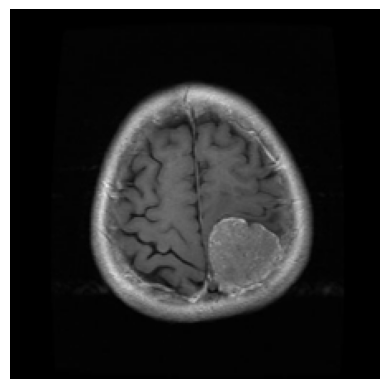

In [153]:
preprocess = transforms.Compose ([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])

img = Image.open('../assets/test_meningioma.jpg')
img = img.convert('RGB')
img = img.resize((224, 224))

pl.imshow(img)
pl.axis('off')
pl.show()

In [154]:
input_tensor: torch.Tensor = preprocess(img).unsqueeze(0)
target_layer: nn.Conv2d = [cnn.features[6]] # Last Conv2d layer

In [155]:
def explain_with_grad_cam (
    model: nn.Module, 
    target_layer : nn.Conv2d, 
    input_tensor : torch.Tensor, 
    target_class : int, 
    original_img : Image 
) -> np.ndarray:
    output = model(input_tensor)
    targets = [ClassifierOutputTarget(target_class)]
    cam = GradCAM(model = model, target_layers = target_layer)
    grayscale_cam = cam(input_tensor = input_tensor, targets = targets)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(np.array(original_img) / 255, grayscale_cam, use_rgb = True)
    return visualization

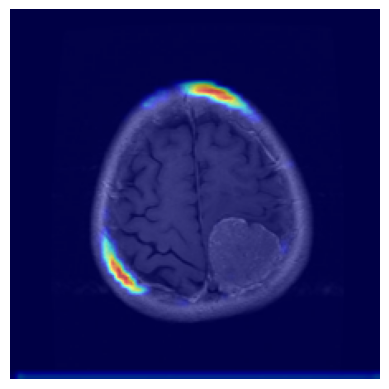

In [156]:
visualization = explain_with_grad_cam (
    cnn, 
    target_layer, 
    input_tensor, 
    classes['meningioma'],
    img
)

pl.imshow(visualization)
pl.axis('off')
pl.show()